# Predict Future Sales
from [kaggle competition](https://www.kaggle.com/c/competitive-data-science-predict-future-sales/)

## 2. EDA and Feature Engineering


In [1]:
import pandas as pd
from matplotlib import pyplot as plt

train = pd.read_csv('data/sales_train_opt_ver1.csv')

In [2]:
# optimize dataset
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
date                             object
date_block_num                   int64
shop_id                          int64
item_id                          int64
item_price                       float64
item_cnt_day                     int64
item_category_id                 int64
shop_loc                         object
shop_loc_dist                    object
shop_loc_pop_2010                float64
shop_loc_pop_2017                float64
shop_loc_pop_rank_2017           float64
shop_loc_pop_change_2010_2017    float64
item_first_categry               object
item_second_categry              object
dtypes: float64(5), int64(5), object(5)
memory usage: 1.1 GB


In [3]:
# timestamp column to datetime type
train['date'] = pd.to_datetime(train['date'])

In [4]:
# float column - optimize size
float_cols = train.select_dtypes(include=['float'])

for fc in float_cols.columns:
    
    train[fc] = pd.to_numeric(train[fc], downcast='float')
    

In [5]:
# convert columns with string values to category column
# apply if the number of total unique values is less than half of the total rows

obj_cols = train.select_dtypes(include=['object'])

for oc in obj_cols.columns:
    
    if len(train[oc].unique()) < .5 * len(train):
        
        train[oc] = train[oc].astype('category')
    

In [6]:
# optimization finished: 
# FROM 1.1GB TO 200MB
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 15 columns):
date                             datetime64[ns]
date_block_num                   int64
shop_id                          int64
item_id                          int64
item_price                       float32
item_cnt_day                     int64
item_category_id                 int64
shop_loc                         category
shop_loc_dist                    category
shop_loc_pop_2010                float32
shop_loc_pop_2017                float32
shop_loc_pop_rank_2017           float32
shop_loc_pop_change_2010_2017    float32
item_first_categry               category
item_second_categry              category
dtypes: category(4), datetime64[ns](1), float32(5), int64(5)
memory usage: 201.6 MB


In [7]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_categry,item_second_categry
0,2013-02-01,0,59,22154,999.000000,1,37,yaroslavl,Central,591486.0,608079.0,25.0,2.8,cinema,blu-ray
1,2013-03-01,0,25,2552,899.000000,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl
2,2013-05-01,0,25,2552,899.000000,-1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl
3,2013-06-01,0,25,2554,1709.050049,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl
4,2013-01-15,0,25,2555,1099.000000,1,56,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,cd of branded production


In [8]:
# since the day part in the timestamp is less meaningful - we exclude 'day'
# and divide the timestamp with two columns : 'year' and 'month'

train['date_month'] = train['date'].apply(lambda x: x.month)
train['date_year'] = train['date'].apply(lambda x: x.year)
train['date_yearmonth'] = train['date'].apply(lambda x: int(str(x.year)+str(x.month)) if x.month > 9
                                             else int(str(x.year)+'0'+str(x.month)))

# and additionally create 'season' column for some products having seasonality.

month_season_mapped = {
    1:'winter', 2:'winter',
    3:'spring', 4:'spring', 5:'spring',
    6:'summer', 7:'summer', 8:'summer', 
    9:'autumn', 10:'autumn', 11:'autumn',
    12:'winter'
}

train['date_season'] = train['date_month'].map(month_season_mapped)

In [10]:
# to visualize the actual income, 
train['revenue'] = train['item_price'] * train['item_cnt_day']

## Total revenue by year
note : not fully represent the whole year's revenue data.
* `2013.01-2013.12`
* `2014.01-2014.12`
* `2015.01-2015.10`

### Significant amount of revenues might have been occurring in last two month (`Nov` and `Dec`) .

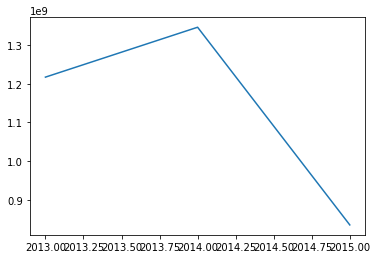

In [11]:
plt.plot([2013,2014,2015], [train[train['date_year']==year]['revenue'].sum() for year in [2013, 2014, 2015]])
plt.show()

# Data flaws
* The train data is supposed to have sales data recorded from `2013-01` to `2015-10`, so that we can predict the `2015-11`.
* However, the train set includes some sales data with timestamp of `2015-11-??` and `2015-12-??` (less than 40k rows)
* Therefore, we need to drop the unintended data rows from the train set.

In [17]:
len(train[train['date_yearmonth'] > 201510])

39067

In [18]:
train = train.drop(train[train['date_yearmonth'] > 201510].index)

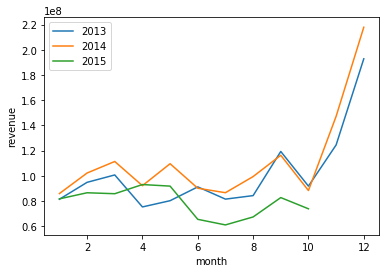

In [19]:
sorted_yearmonth_uniques = sorted(train['date_yearmonth'].unique().tolist())
yearmonths_2013 = [yearmonth_2013 for yearmonth_2013 in sorted_yearmonth_uniques if yearmonth_2013 < 201400]
revenues_2013 = [train[train['date_yearmonth']==ym2013]['revenue'].sum() for ym2013 in yearmonths_2013]

yearmonths_2014 = [yearmonth_2014 for yearmonth_2014 in sorted_yearmonth_uniques if (yearmonth_2014 < 201500) and (yearmonth_2014 > 201312)]
revenues_2014 = [train[train['date_yearmonth']==ym2014]['revenue'].sum() for ym2014 in yearmonths_2014]

yearmonths_2015 = [yearmonth_2015 for yearmonth_2015 in sorted_yearmonth_uniques if yearmonth_2015 > 201500]
revenues_2015 = [train[train['date_yearmonth']==ym2015]['revenue'].sum() for ym2015 in yearmonths_2015]

plt.plot(range(1,13), revenues_2013, label='2013')
plt.plot(range(1,13), revenues_2014, label='2014')
plt.plot(range(1,11), revenues_2015, label='2015')
plt.xlabel('month')
plt.ylabel('revenue')
plt.legend()
plt.show()

## Total revenue by year-month

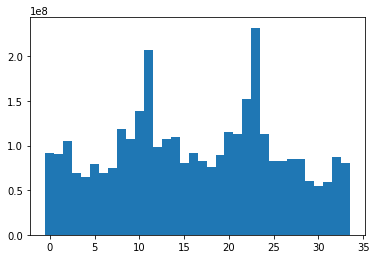

In [256]:
sorted_yearmonth_uniques = sorted(train['date_block_num'].unique().tolist())

plt.bar(sorted_yearmonth_uniques, 
         [train[train['date_block_num']==yearmonth]['revenue'].sum() for yearmonth in sorted_yearmonth_uniques],
       width=1,)
plt.show()

## Total revenue from `Jan` to `Oct` in year `2013`, `2014` and `2015`

* In `2015`, the total revenue before `Nov` - winter season - decreased relatively.
* From the national economy indices, we can guess the decrease in revenue due to the economical depression.

SOURCE : https://www.focus-economics.com/countries/russia

![russia-economy-indices](data/russia-economy.png)

### We can add the major (yearly / monthly) economic indices as feature columns in train data.

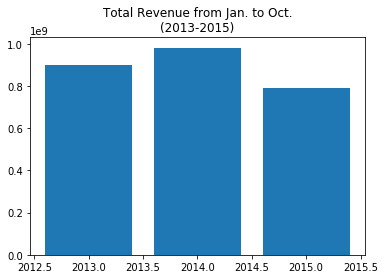

In [20]:
plt.bar([2013,2014,2015], height=[sum(revenues_2013[:10]), sum(revenues_2014[:10]), sum(revenues_2015)])
plt.title('Total Revenue from Jan. to Oct.\n(2013-2015)')
plt.show()

In [22]:
# economic index list (in order)
# economic indices tend to be correlated highly.
# we will choose the best feature out of the economic indices.

# gdp_per_capita_usd
# economic_growth_perc
# consumption_perc
# retail_sales_perc
# unemployment_rate
# inflation_rate_cpi_perc
# inflation_rate_ppi_perc

years = [2013, 2014, 2015]
gdp_per_capita_usd = [15553, 14374, 9503]
economic_growth_perc = [1.3, 0.7, -2.8]
consumption_perc = [4.4, 2.0, -9.8]
retail_sales_perc = [3.9, 2.7, -9.8]
unemployment_rate = [5.5, 5.2, 5.6]
inflation_rate_cpi_perc = [6.8, 7.8, 15.5]
inflation_rate_ppi_perc = [3.7, 5.9, 10.7]

eco_indices_names = ['gdp_per_capita_usd', 'economic_growth_perc',
                    'consumption_growth_perc', 'retail_sales_perc',
                    'unemployment_rate', 'inflation_rate_cpi_perc',
                    'inflation_rate_ppi_perc']
eco_indices_values = [
    [15553, 14374, 9503],
    [1.3, 0.7, -2.8],
    [4.4, 2.0, -9.8],
    [3.9, 2.7, -9.8],
    [5.5, 5.2, 5.6],
    [6.8, 7.8, 15.5],
    [3.7, 5.9, 10.7]
]


for i, indexname in enumerate(eco_indices_names):
    
    train[indexname] = train['date_year'].map(dict(zip(years,
                                                      eco_indices_values[i])))



In [23]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,...,date_yearmonth,date_season,revenue,gdp_per_capita_usd,economic_growth_perc,consumption_growth_perc,retail_sales_perc,unemployment_rate,inflation_rate_cpi_perc,inflation_rate_ppi_perc
0,2013-02-01,0,59,22154,999.000000,1,37,yaroslavl,Central,591486.0,...,201302,winter,999.000000,15553,1.3,4.4,3.9,5.5,6.8,3.7
1,2013-03-01,0,25,2552,899.000000,1,58,moscow,Central,11503501.0,...,201303,spring,899.000000,15553,1.3,4.4,3.9,5.5,6.8,3.7
2,2013-05-01,0,25,2552,899.000000,-1,58,moscow,Central,11503501.0,...,201305,spring,-899.000000,15553,1.3,4.4,3.9,5.5,6.8,3.7
3,2013-06-01,0,25,2554,1709.050049,1,58,moscow,Central,11503501.0,...,201306,summer,1709.050049,15553,1.3,4.4,3.9,5.5,6.8,3.7
4,2013-01-15,0,25,2555,1099.000000,1,56,moscow,Central,11503501.0,...,201301,winter,1099.000000,15553,1.3,4.4,3.9,5.5,6.8,3.7


## Before further EDA & Visualization

* Our goal is to predict the monthly sales in **Nov 2015** from each shop
  - List of items(products) slightly differ from every month
* Timestamp column in `train` dataset is recorded by day
  - We need to group the data fit to our prediction goal before EDA & visualization process


In [23]:
pd.read_csv('data/sales_test.csv').head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


## Re-format the dataframe

* `AS WAS` : sales recorded daily grouped by `shop_id` + `item_id`
* `TO BE` : sales recorded monthly grouped by `shop_id` + `item_id`

### `60` shops total
### `21783` items sold

In [24]:
len(train['shop_id'].unique())

60

In [25]:
len(train['item_id'].unique())

21783

In [37]:
pd.read_csv('data/sales_train.csv').head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [38]:
train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_cnt_day'].sum().reset_index()

,shop_id,item_id,date_block_num,item_cnt_day
0,0,30,1,31
1,0,31,1,11
2,0,32,0,6
3,0,32,1,10
4,0,33,0,3
5,0,33,1,3
6,0,35,0,1
7,0,35,1,14
8,0,36,1,1
9,0,40,1,1


In [40]:
train.groupby(['shop_id', 'item_id', 'date_block_num'])['item_price'].mean().reset_index()

,shop_id,item_id,date_block_num,item_price
0,0,30,1,265.000000
1,0,31,1,434.000000
2,0,32,0,221.000000
3,0,32,1,221.000000
4,0,33,0,347.000000
5,0,33,1,347.000000
6,0,35,0,247.000000
7,0,35,1,247.000000
8,0,36,1,357.000000
9,0,40,1,127.000000


In [36]:
train.groupby(['shop_id', 'item_id', 'date_block_num'])['revenue'].sum().reset_index()

,shop_id,item_id,date_block_num,revenue
0,0,30,1,8215.000000
1,0,31,1,4774.000000
2,0,32,0,1326.000000
3,0,32,1,2210.000000
4,0,33,0,1041.000000
5,0,33,1,1041.000000
6,0,35,0,247.000000
7,0,35,1,3458.000000
8,0,36,1,357.000000
9,0,40,1,127.000000


## Top 5 area in terms of total `revenue`

In [33]:
total_revenue_by_loc

shop_loc
moscow              1.117292e+09
saint petersburg    2.115047e+08
yakutsk             1.888447e+08
voronezh            1.653486e+08
online              1.589883e+08
khimki              1.414879e+08
tyumen              1.208360e+08
krasnoyarsk         1.101306e+08
ufa                 1.001674e+08
nizhny novgorod     7.738515e+07
samara              7.436000e+07
surgut              7.346460e+07
sergiyev posad      7.307985e+07
kaluga              6.774911e+07
rostov-on-don       6.757697e+07
omsk                6.463007e+07
kursk               6.401056e+07
chekhov             5.774775e+07
kolomna             5.654960e+07
kazan               5.219795e+07
novosibirsk         4.568531e+07
yaroslavl           4.470459e+07
krasnodar           4.344662e+07
volzhsky            4.005388e+07
vologda             3.750511e+07
balashikha          2.959257e+07
tomsk               2.697086e+07
zhukovsky           1.966052e+07
export              1.637284e+07
mytishchi           5.778183e+06
N

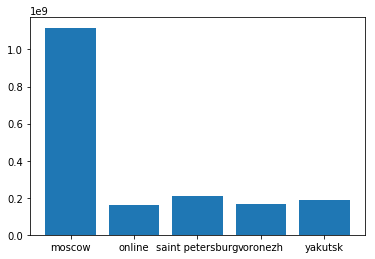

In [32]:
total_revenue_by_loc = train.groupby('shop_loc')['revenue'].sum().sort_values(ascending=False)
plt.bar(total_revenue_by_loc.index[:5], height=total_revenue_by_loc.values[:5])
plt.show()

In [258]:
tt = train[(train['shop_id'] == 5) & (train['item_id'] == 6675)]
tt.groupby('date_block_num')['revenue'].sum()

date_block_num
10    383790.000000
11    394830.000000
12    167940.000000
13    303840.000000
14    324850.003906
15    206910.000000
16    160930.000000
17    137940.000000
18    110151.000000
19    181910.000000
20    114943.000000
21     60871.000000
22     20990.000000
23     24990.000000
24     49980.000000
26     49981.000000
28     26990.000000
29     23491.000000
Name: revenue, dtype: float64

In [259]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_categry,item_second_categry,date_month,date_year,revenue,date_yearmonth,date_season
0,2013-02-01,0,59,22154,999.000000,1,37,yaroslavl,Central,591486.0,608079.0,25.0,2.8,cinema,blu-ray,2,2013,999.000000,201302,winter
1,2013-03-01,0,25,2552,899.000000,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,3,2013,899.000000,201303,spring
2,2013-05-01,0,25,2552,899.000000,-1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,5,2013,-899.000000,201305,spring
3,2013-06-01,0,25,2554,1709.050049,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,6,2013,1709.050049,201306,summer
4,2013-01-15,0,25,2555,1099.000000,1,56,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,cd of branded production,1,2013,1099.000000,201301,winter


# Data structure to be reformed as `records by month`

### Columns to inlcude
* `date_block_num` - cumulative number of months
* `shop_id` - unique id for shop
* `item_id` - unique id for item
* `item_price` - mean item price for the month
  * **We need to infer the values in this column from `train` dataset for setting `test` set**
  * **Sub model to predict the monthly price from the prices trend in the past can be considered.**
* `item_cnt_month` - number of items sold in the month
* `item_first_category` - broad categorization of the item
* `item_second_category` - detailed categorization of the item
* `date_month` - month of the date
* `date_year` - year of the date
* `shop_loc` - city name where the shop is located at
* `shop_loc_dist` - broader sector name for `shop_loc`
* `shop_loc_pop_2010` - population of city in 2010 from census
* `shop_loc_pop_2017` - population of city in 2017 estimated
* `shop_loc_pop_rank_2017` - rank by city population in 2017
* `shop_loc_pop_change_2010_2017` - change ratio of city population from 2010 to 2017
* **`revenue`** - revenue occurred for the item in the month // `target column`

### Columns to exclude
* `item_category_id` - This column has less detailed information to `item_first_category` and `item_second_category`.


## Case for item_id `6675` --- relationship among `revenue` & `price` & `num of sold`
* To visualize the inter-relationship, normalize each column and plot.

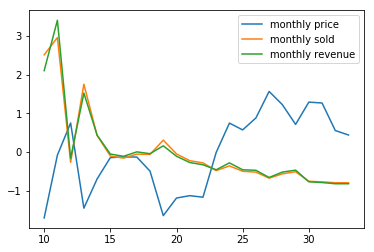

In [260]:
# by month (cumulative)
item_6675_mean_price_by_month = train[train['item_id'] == 6675][['item_price', 'date_block_num']].groupby('date_block_num')['item_price'].mean()
item_6675_total_num_sold_by_month = train[train['item_id'] == 6675][['item_cnt_day', 'date_block_num']].groupby('date_block_num')['item_cnt_day'].sum()
item_6675_total_rev_by_month = train[train['item_id'] == 6675][['revenue', 'date_block_num']].groupby('date_block_num')['revenue'].sum()

date_block_num_unique = item_6675_mean_price_by_month.index

def norm(series):
    return (series - series.mean())/series.std()

plt.plot(date_block_num_unique, norm(item_6675_mean_price_by_month), label='monthly price')
plt.plot(date_block_num_unique, norm(item_6675_total_num_sold_by_month), label='monthly sold')
plt.plot(date_block_num_unique, norm(item_6675_total_rev_by_month), label='monthly revenue')
plt.legend()
plt.show()

In [189]:
item_6675_total_num_sold_by_month.mean()

428.70833333333331

In [261]:
item_6675_total_num_sold_by_month

date_block_num
10    1764
11    2002
12     283
13    1359
14     654
15     370
16     341
17     396
18     392
19     589
20     399
21     306
22     275
23     169
24     234
25     160
26     148
27      65
28     124
29     154
30      22
31      14
32       2
33       2
Name: item_cnt_day, dtype: int64

## Insights in the case of `item_id = 6675`

* Interestingly, we can find a strong relationship between `monthly revenue` and `monthly number of sold`
* In contrast, there seems relateively low relationship between `monthly revenue` and `monthly price`

### We can consider an additional factor for each product - **`Price Elasticity of Demand`**
* For products with high price elasticity of demand:
  * The changes in price affect the demand
* For products with low price elasticity of demand
  * The changes in price don't affect the demand
  
### One more step - we can categorize the type of each product in terms of `Price Elasticity of Demand` 
* Essential goods --- low price elasticity of demand
* Luxury --- high price elasticity of demand
* We can 


In [161]:
print(train['item_first_categry'].unique().tolist())

['cinema', 'music', 'games', 'pc games', 'programs', 'books', 'gifts', 'accessories', 'game consoles', 'payment cards', 'clean media (piece)', 'clean carriers (spire)', 'office', 'pc', 'elements of a food', 'delivery of goods', 'movies', 'tickets (digital)', 'android games', 'mac games', 'official']


![](https://wikimedia.org/api/rest_v1/media/math/render/svg/3dc579ea00e87263d839bac3f1cdeb37937f70a4)

In [184]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,shop_loc,shop_loc_dist,shop_loc_pop_2010,shop_loc_pop_2017,shop_loc_pop_rank_2017,shop_loc_pop_change_2010_2017,item_first_categry,item_second_categry,date_month,date_year,revenue,date_yearmonth,date_season
0,2013-02-01,0,59,22154,999.000000,1,37,yaroslavl,Central,591486.0,608079.0,25.0,2.8,cinema,blu-ray,2,2013,999.000000,201302,winter
1,2013-03-01,0,25,2552,899.000000,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,3,2013,899.000000,201303,spring
2,2013-05-01,0,25,2552,899.000000,-1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,5,2013,-899.000000,201305,spring
3,2013-06-01,0,25,2554,1709.050049,1,58,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,vinyl,6,2013,1709.050049,201306,summer
4,2013-01-15,0,25,2555,1099.000000,1,56,moscow,Central,11503501.0,12228685.0,1.0,6.3,music,cd of branded production,1,2013,1099.000000,201301,winter


## Considering factor `'Seasonality'`

* Some products have seasonal sales patterns - the others got sold in a limited period.
* We can determine which product is seasonal or not
  * And create a column to represent the information.

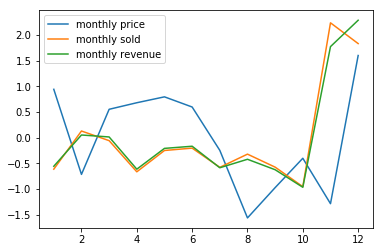

In [262]:
# by month (absolute)
item_6675_mean_price_by_month = train[train['item_id'] == 6675][['item_price', 'date_month']].groupby('date_month')['item_price'].mean()
item_6675_total_num_sold_by_month = train[train['item_id'] == 6675][['item_cnt_day', 'date_month']].groupby('date_month')['item_cnt_day'].sum()
item_6675_total_rev_by_month = train[train['item_id'] == 6675][['revenue', 'date_month']].groupby('date_month')['revenue'].sum()

date_block_num_unique = item_6675_mean_price_by_month.index

def norm(series):
    return (series - series.mean())/series.std()

plt.plot(date_block_num_unique, norm(item_6675_mean_price_by_month), label='monthly price')
plt.plot(date_block_num_unique, norm(item_6675_total_num_sold_by_month), label='monthly sold')
plt.plot(date_block_num_unique, norm(item_6675_total_rev_by_month), label='monthly revenue')
plt.legend()
plt.show()

**However, the concept `'Seasonality'` could be more or less a narrow concept.**

## We can calculate `hot sales month index` 

grouping data by `date_block_num`, not by `date_month` - in this way, values of `hot sales month` column can represent information including seasonality as well.

* `more than twice` of the mean number of sold --- `month on trend`
* `less than half` of the mean number of sold --- `month out of trend`
  

In [140]:
train[train['item_id'] == 1][['item_price', 'date_block_num']].groupby('date_block_num')['item_price'].mean()

date_block_num
15    4490.0
18    4490.0
19    4490.0
20    4490.0
21    4490.0
Name: item_price, dtype: float32

In [117]:
train[(train['shop_id'] == 5) & (train['item_id'] == 6675)].groupby('date_yearmonth')['revenue'].sum()

date_yearmonth
201301     53970.000000
201306     18990.000000
201311    383790.000000
201312    321870.000000
201401     22990.000000
201402    113940.000000
201403    373830.003906
201404    257890.000000
201405    142940.000000
201406    193920.000000
201407    110352.000000
201408    129136.000000
201409    113345.000000
201410    249972.000000
201411     82960.000000
201412     24990.000000
201501     23491.000000
201502     24990.000000
201503     26490.000000
201504     23491.000000
201505     26990.000000
201509     24990.000000
201512     24591.000000
Name: revenue, dtype: float64

In [95]:
train.groupby('item_id')['revenue'].sum().sort_values(ascending=False)[:10]

item_id
6675     2.193915e+08
3732     4.361798e+07
13443    3.433125e+07
3734     3.106516e+07
3733     2.229886e+07
16787    2.190784e+07
3731     1.998348e+07
13405    1.812548e+07
17717    1.720083e+07
5823     1.715185e+07
Name: revenue, dtype: float64

In [ ]:
train['shop_id'].unique()

## Distribution of item prices
* 

In [32]:
from matplotlib import pyplot as plt

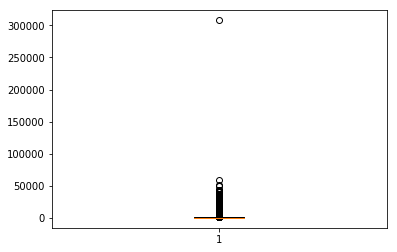

In [61]:
plt.boxplot(train['item_price'])
plt.show()

In [50]:
print(len(train[train['item_price']<1000]))
print(len(train[train['item_price']>=1000]))
train['item_price'].describe()

2269732
666117


count    2.935849e+06
mean     8.908532e+02
std      1.729800e+03
min     -1.000000e+00
25%      2.490000e+02
50%      3.990000e+02
75%      9.990000e+02
max      3.079800e+05
Name: item_price, dtype: float64

In [82]:
train['item_price'].value_counts()

pandas.core.series.Series

## Item price in over 75% of total sales record -> Less than `1000`
* Create column `item_price_range` to categorize the item prices by range for visualization and further modeling

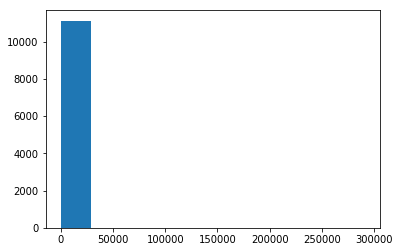

In [60]:
plt.hist(train[train['item_price'] < 1000]['item_price'].value_counts())
plt.show()

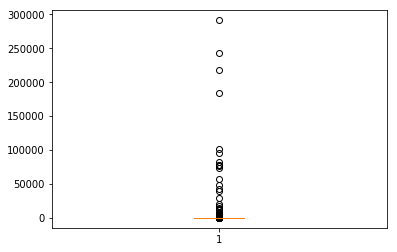

In [56]:
plt.boxplot(train[train['item_price'] < 1000]['item_price'].value_counts())
plt.show()

In [55]:
train[train['item_price'] < 1000]['item_price'].value_counts()

299.000000    291352
399.000000    242603
149.000000    218432
199.000000    184044
349.000000    101461
599.000000     95673
999.000000     82784
799.000000     77882
249.000000     77685
699.000000     76493
499.000000     73078
899.000000     57156
99.000000      48955
449.000000     43205
549.000000     39080
5.000000       29702
169.000000     20848
749.000000     17351
229.000000     14209
649.000000     12460
849.000000     12102
98.000000      11141
349.500000      9353
419.000000      8697
299.500000      7958
58.000000       7876
599.500000      7779
28.000000       7725
949.000000      7540
198.000000      5701
               ...  
174.184998         1
170.050003         1
172.466660         1
170.440002         1
170.679993         1
170.824997         1
171.071426         1
171.250000         1
171.289993         1
171.661804         1
171.666672         1
171.669998         1
172.025314         1
172.220001         1
172.333328         1
172.494995         1
174.169998   

In [ ]:
train['item_price_range1']

## Total sales by location (`shop_loc`) in the entire period

In [30]:
# total list of unique values in 'shop_loc' column

print(train['shop_loc'].unique().tolist())

['yaroslavl', 'moscow', 'kursk', 'krasnoyarsk', 'volzhsky', 'voronezh', 'krasnodar', 'balashikha', 'yakutsk', 'kolomna', 'kaluga', 'zhukovsky', 'kazan', 'online', 'ufa', 'nizhny novgorod', 'chekhov', 'khimki', 'surgut', 'tyumen', 'saint petersburg', 'rostov-on-don', 'omsk', 'samara', 'novosibirsk', 'sergiyev posad', 'vologda', 'export', 'tomsk', 'mytishchi']


In [ ]:
train.groupby('shop_loc')['']